<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
<center>
Авторы материала: Ольга Дайховская (@aiho), Юрий Кашницкий (@yorko). 
    
Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 7 (демо)
## <center> Обучение без учителя: метод главных компонент и кластеризация

В этом задании мы разберемся с тем, как работают методы снижения размерности и кластеризации данных. Заодно еще раз попрактикуемся в задаче классификации.

Мы будем работать с набором данных [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). Скачайте данные [отсюда](https://drive.google.com/file/d/14RukQ0ylM2GCdViUHBBjZ2imCaYcjlux/view?usp=sharing). Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S3 (подробнее про признаки – по ссылке на UCI выше), также известен вид активности человека с телефоном в кармане – ходил ли он, стоял, лежал, сидел или шел вверх/вниз по лестнице. 

Вначале мы представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков. Затем решим задачу определения вида физической активности именно как задачу классификации. 

Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://docs.google.com/forms/d/1qzcrfsNFy-e4TW59v2fqMj_OTom2SIOxtq4MWlI92p0).

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

In [38]:
X_train = np.loadtxt("C:/samsung_HAR/samsung_HAR/samsung_train.txt")
y_train = np.loadtxt("C:/samsung_HAR/samsung_HAR/samsung_train_labels.txt").astype(int)

X_test = np.loadtxt("C:/samsung_HAR/samsung_HAR/samsung_test.txt")
y_test = np.loadtxt("C:/samsung_HAR/samsung_HAR/samsung_test_labels.txt").astype(int)

In [39]:
# Проверим размерности
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

Для кластеризации нам не нужен вектор ответов, поэтому будем работать с объединением обучающей и тестовой выборок. Объедините *X_train* с *X_test*, а *y_train* – с *y_test*. 

In [40]:
# Ваш код здесь
X = np.vstack([X_train, X_test])
y = np.hstack([y_train, y_test])

Определим число уникальных значений меток целевого класса.

In [41]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [42]:
n_classes = np.unique(y).size

[Эти метки соответствуют:](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)
- 1 - ходьбе
- 2 - подъему вверх по лестнице
- 3 - спуску по лестнице
- 4 - сидению
- 5 - стоянию
- 6 - лежанию

*уж простите, если звучание этих существительных кажется корявым :)*

Отмасштабируйте выборку с помощью `StandardScaler` с параметрами по умолчанию.

In [43]:
# Ваш код здесь
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Понижаем размерность с помощью PCA, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии исходных (отмасштабированных) данных. Используйте отмасштабированную выборку и зафиксируйте random_state (константа RANDOM_STATE).

In [44]:
# Ваш код здесь
pca = PCA(0.90, random_state=RANDOM_STATE)
X_pca = pca.fit(X_scaled)

**Вопрос 1:**<br>
Какое минимальное число главных компонент нужно выделить, чтобы объяснить 90% дисперсии исходных (отмасштабированных) данных?

In [45]:
###### Ваш код здесь
print('{} - столько главных компонентов нужно для объяснения 90% дисперсии'.format(X_pca.n_components_))
print('{} - столько % дисперсии приходится на главную компоненту'.format(round(100 * X_pca.explained_variance_ratio_[0])))

65 - столько главных компонентов нужно для объяснения 90% дисперсии
51.0 - столько % дисперсии приходится на главную компоненту


**Варианты:**
- 56 
- ***65*** - верный ответ
- 66
- 193

**Вопрос 2:**<br>
Сколько процентов дисперсии приходится на первую главную компоненту? Округлите до целых процентов. 

**Варианты:**
- 45
- ***51*** - верный ответ
- 56
- 61

Визуализируйте данные в проекции на первые две главные компоненты.

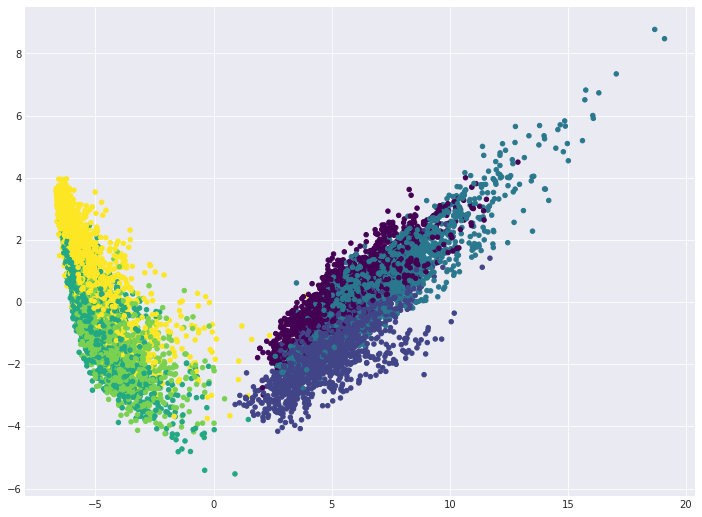

In [46]:
# Ваш код здесь
pca1 = PCA(0.9, random_state=RANDOM_STATE)
X_reduced = pca1.fit_transform(X)

plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, s=20, cmap='viridis');

**Вопрос 3:**<br>
Если все получилось правильно, Вы увидите сколько-то кластеров, почти идеально отделенных друг от друга. Какие виды активности входят в эти кластеры?<br>

**Ответ:**
- 1 кластер: все 6 активностей
- ***2 кластера: (ходьба, подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)***
- 3 кластера: (ходьба), (подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 6 кластеров

Сделайте кластеризацию данных методом `KMeans`, обучив модель на данных со сниженной за счет PCA размерностью. В данном случае мы подскажем, что нужно искать именно 6 кластеров, но в общем случае мы не будем знать, сколько кластеров надо искать.

Параметры:

- **n_clusters** = n_classes (число уникальных меток целевого класса)
- **n_init** = 100
- **random_state** = RANDOM_STATE (для воспроизводимости результата)

Остальные параметры со значениями по умолчанию.

In [47]:
%%time
kmeans = KMeans(n_clusters=n_classes, n_init=100, random_state=RANDOM_STATE).fit(X_scaled)

Wall time: 1min 6s


Визуализируйте данные в проекции на первые две главные компоненты. Раскрасьте точки в соответствии с полученными метками кластеров.

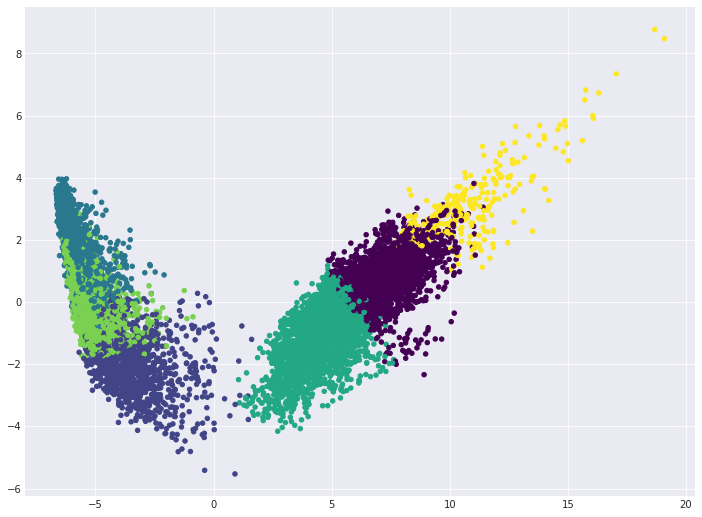

In [48]:
# Ваш код здесь
cluster_labels = kmeans.labels_
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=cluster_labels, s=20,  cmap='viridis');

Посмотрите на соответствие между метками кластеров и исходными метками классов и на то, какие виды активностей алгоритм `KMeans` путает.

In [49]:
from pandas import crosstab
tab = crosstab(y, cluster_labels, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['все']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,все
ходьба,742,0,0,903,0,77,1722
подъем вверх по лестнице,295,2,0,1242,0,5,1544
спуск по лестнице,889,0,0,321,0,196,1406
сидение,0,451,91,1,1234,0,1777
стояние,0,566,0,0,1340,0,1906
лежание,0,330,1556,5,53,0,1944
все,1926,1349,1647,2472,2627,278,10299


Видим, что каждому классу (т.е. каждой активности) соответствуют несколько кластеров. Давайте посмотрим на максимальную долю объектов в классе, отнесенных к какому-то одному кластеру. Это будет простой метрикой, характеризующей, насколько легко класс отделяется от других при кластеризации. 

Пример: если для класса "спуск по лестнице", в котором 1406 объектов,  распределение кластеров такое:
 - кластер 1 – 900
 - кластер 3 – 500
 - кластер 6 – 6,
 
то такая доля будет 900 / 1406 $\approx$ 0.64.
 

**Вопрос 4:**<br>
Какой вид активности отделился от остальных лучше всего в терминах простой  метрики, описанной выше?<br>

**Ответ:**
- ходьба
- стояние
- спуск по лестнице
- ***перечисленные варианты не подходят*** - лучше всего отделилась активность - подъем вверх по лестнице

In [50]:
print('ходьба ', 903 / 1722)
print('стояние ', 1340 / 1906)
print('спуск по лестнице ', 889 / 1406)

print('лежание ', 1556 / 1944)
print('подъем по лестнице ', 1242 / 1544)

ходьба  0.524390243902439
стояние  0.7030430220356768
спуск по лестнице  0.6322901849217639
лежание  0.8004115226337448
подъем по лестнице  0.8044041450777202


Видно, что kMeans не очень хорошо отличает только активности друг от друга. Используйте метод локтя, чтобы выбрать оптимальное количество кластеров. Параметры алгоритма и данные используем те же, что раньше, меняем только `n_clusters`.

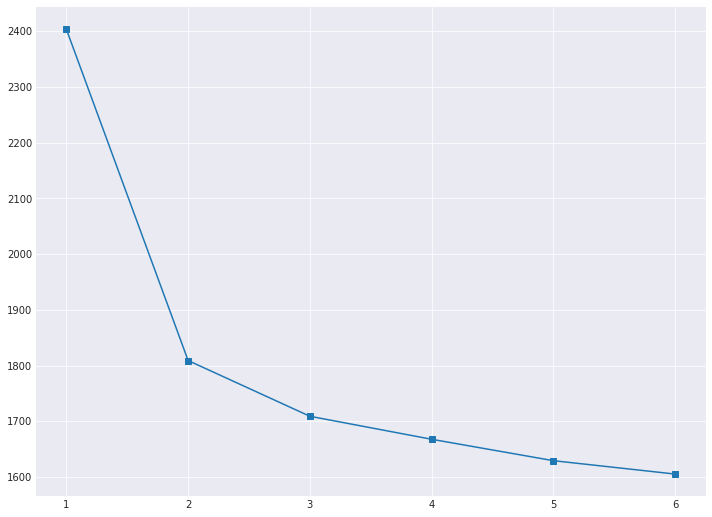

In [51]:
# Ваш код здесь
inertia = []
for k in tqdm_notebook(range(1, n_classes + 1)):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(X_scaled)
    inertia.append(np.sqrt(kmeans.inertia_))

plt.plot(range(1, 7), inertia, marker='s');

**Вопрос 5:**<br>
Какое количество кластеров оптимально выбрать, согласно методу локтя?<br>

**Ответ:**
- 1
- ***2*** - - верный ответ, после 4-го кластера убывание идет уже не так заметно
- 3 
- 4

Попробуем еще один метод кластеризации, который описывался в статье – агломеративную кластеризацию.

In [52]:
%%time
ag = AgglomerativeClustering(n_clusters=2, 
                             linkage='ward').fit_predict(X_scaled)

Wall time: 40.7 s


In [53]:
%%time
kmeans = KMeans(n_clusters=2, n_init=100, random_state=RANDOM_STATE).fit_predict(X_scaled)

Wall time: 31.3 s


Посчитайте Adjusted Rand Index (`sklearn.metrics`) для получившегося разбиения на кластеры и для `KMeans` с параметрами из задания к 4 вопросу.

In [54]:
# Ваш код здесь
print('{} - ARI для AC'.format(metrics.adjusted_rand_score(y, ag)))
print('{} - ARI для KMeans'.format(metrics.adjusted_rand_score(y, kmeans)))

0.3325322071548514 - ARI для AC
0.3296106738894193 - ARI для KMeans


**Вопрос 6:**<br>
Отметьте все верные утверждения.<br>

***Все варианты ответов верны.***

**Варианты:**
- Согласно ARI, KMeans справился с кластеризацией хуже, чем Agglomerative Clustering
- Для ARI не имеет значения какие именно метки присвоены кластерам, имеет значение только разбиение объектов на кластеры
- В случае случайного разбиения на кластеры ARI будет близок к нулю

Можно заметить, что задача не очень хорошо решается именно как задача кластеризации, если выделять несколько кластеров (> 2). Давайте теперь решим задачу классификации, вспомнив, что данные у нас размечены.  

Для классификации используйте метод опорных векторов – класс `sklearn.svm.LinearSVC`. Мы в курсе отдельно не рассматривали этот алгоритм, но он очень известен, почитать про него можно, например, в материалах Евгения Соколова –  [тут](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem11_linear.pdf). 

Настройте для `LinearSVC` гиперпараметр `C` с помощью `GridSearchCV`. 

- Обучите новый `StandardScaler` на обучающей выборке (со всеми исходными признаками), прмиените масштабирование к тестовой выборке
- В `GridSearchCV` укажите  cv=3.

In [55]:
# Ваш код здесь
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [56]:
%%time
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(svc, svc_params, cv=3)
grid.fit(X_train_scaled, y_train)

Wall time: 1min


In [ ]:
# Ваш код здесь
best_svc.best_params_, best_svc.best_score_

In [58]:
# Ваш код здесь
print('Лучшим значением С является {}'.format(grid.best_params_['C']))

Лучшим значением С является 0.1


**Вопрос 7**<br>
Какое значение гиперпараметра `C` было выбрано лучшим по итогам кросс-валидации?<br>

**Ответ:**
- 0.001
- 0.01
- ***0.1*** - верный ответ
- 1
- 10

In [59]:
y_predicted = grid.predict(X_test_scaled)

In [60]:
tab = crosstab(y_test, y_predicted, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице', 
             'сидение', 'стояние', 'лежание', 'все']
tab.columns = tab.index
tab

,ходьба,подъем вверх по лестнице,спуск по лестнице,сидение,стояние,лежание,все
ходьба,479,11,4,2,0,0,496
подъем вверх по лестнице,4,465,1,1,0,0,471
спуск по лестнице,1,2,416,1,0,0,420
сидение,0,4,0,433,52,2,491
стояние,0,0,0,16,516,0,532
лежание,0,0,0,0,6,531,537
все,484,482,421,453,574,533,2947


**Вопрос 8:**<br>
Какой вид активности SVM определяет хуже всего в терминах точности? Полноты? <br>

**Ответ:**
- по точности – подъем вверх по лестнице, по полноте – лежание
- по точности – лежание, по полноте – сидение
- по точности – ходьба, по полноте – ходьба
- ***по точности – стояние, по полноте – сидение*** - верный ответ

In [61]:
print(metrics.classification_report(y_test, y_predicted))

             precision    recall  f1-score   support

          1       0.99      0.97      0.98       496
          2       0.96      0.99      0.98       471
          3       0.99      0.99      0.99       420
          4       0.96      0.88      0.92       491
          5       0.90      0.97      0.93       532
          6       1.00      0.99      0.99       537

avg / total       0.96      0.96      0.96      2947



Наконец, проделайте то же самое, что в 7 вопросе, только добавив PCA.

- Используйте выборки `X_train_scaled` и `X_test_scaled`
- Обучите тот же PCA, что раньше, на отмасшабированной обучающей выборке, примените преобразование к тестовой
- Настройте гиперпараметр `C` на кросс-валидации по обучающей выборке с PCA-преобразованием. Вы заметите, насколько это проходит быстрее, чем раньше.

**Вопрос 9:**<br>
Какова разность между лучшим качеством (долей верных ответов) на кросс-валидации в случае всех 561 исходных признаков и во втором случае, когда применялся метод главных компонент? Округлите до целых процентов.<br>

**Варианты:**
- Качество одинаковое
- 2%
- ***4%*** - верный ответ
- 10%
- 20%

In [62]:
new_pca = PCA(n_components=0.9, random_state=RANDOM_STATE)
X_train_pca = new_pca.fit_transform(X_train_scaled)
X_test_pca = new_pca.transform(X_test_scaled)

In [63]:
%%time
new_grid = GridSearchCV(svc, svc_params, cv=3)
new_grid.fit(X_train_pca, y_train)

Wall time: 13.9 s


In [64]:
new_grid.best_params_, new_grid.best_score_

({'C': 0.1}, 0.8986670293797606)

In [65]:
best_svc_score = grid.best_score_
best_svc_pca_score = new_grid.best_score_

In [66]:
round(100 * (best_svc_score - best_svc_pca_score))

4.0

**Вопрос 10:**<br>
Выберите все верные утверждения:

**Варианты:**
- Метод главных компонент в данном случае позволил уменьшить время обучения модели, при этом качество (доля верных ответов на кросс-валидации) очень пострадало, более чем на 10%
- ***PCA можно использовать для визуализации данных, однако для этой задачи есть и лучше подходящие методы, например, tSNE. Зато PCA имеет меньшую вычислительную сложность***
- ***PCA строит линейные комбинации исходных признаков, и в некоторых задачах они могут плохо интерпретироваться человеком***